In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.tree import export_text

from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer

from sklearn.ensemble import RandomForestRegressor

from IPython.display import display

from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt

In [2]:
#!wget 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'

In [3]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
price_logs = np.log1p(df.median_house_value)

In [5]:
df = df.fillna(0)

In [6]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [8]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [9]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [10]:
val_dicts= df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.
Which feature is used for splitting the data?

- **ocean_proximity=INLAND <-**
- total_rooms
- latitude
- population


In [11]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
#Decision stump
tree_text = export_text(dt, feature_names=dv.feature_names_)
print(tree_text)

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



**Answer Question 1:** ocean_proximity=INLAND

## Question 2

Train a random forest model with these parameters:

n_estimators=10
random_state=1
n_jobs=-1 (optional - to make training faster)
What's the RMSE of this model on validation?

- 0.05
- **0.25 <-** 
- 0.55
- 0.85


In [13]:
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [14]:
y_pred = rf.predict(X_val)

In [15]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [16]:
np.round(rmse(y_val, y_pred),2)

0.25

In [17]:
np.round(np.sqrt(mean_squared_error(y_val, y_pred)),2)

0.25

**Answer Question 2:** 0.25

## Question 3
Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.
Set random_state to 1.
Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving?

- 10
- 55
- 75
- **150 <-**

In [18]:
from tqdm.auto import tqdm

In [19]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n,
                                random_state=1,
                                n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n, score))

  0%|          | 0/20 [00:00<?, ?it/s]

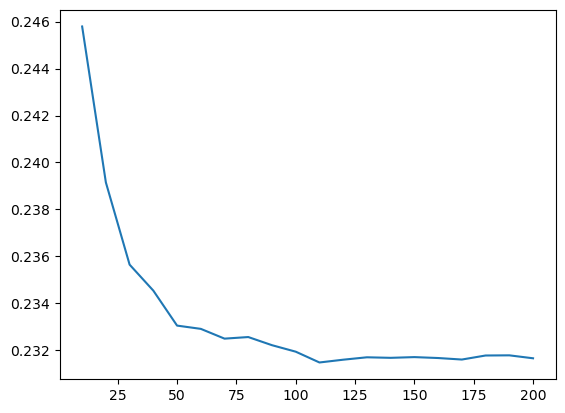

In [20]:
columns = ['n_estimators','rmse']
df_scores = pd.DataFrame(scores, columns=columns)
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.show()

**Answer Question 3:** 150

## Question 4
Let's select the best max_depth:

Try different values of max_depth: [10, 15, 20, 25]

For each of these values, try different values of n_estimators from 10 till 200 (with step 10).Fix the random seed: random_state=1

What's the best max_depth:

- 10
- 15
- 20
- **25 <-**

In [21]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    
    for n in tqdm(range(10, 201, 10)):
        
        rf = RandomForestRegressor(n_estimators=n,
                                        max_depth=d,
                                        random_state=1,
                                        n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((n, d, score))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [22]:
columns = ['n_estimators', 'max_depth', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,n_estimators,max_depth,rmse
0,10,10,0.254601
1,20,10,0.252599
2,30,10,0.251514
3,40,10,0.250963
4,50,10,0.250117
...,...,...,...
75,160,25,0.231489
76,170,25,0.231449
77,180,25,0.231583
78,190,25,0.231552


In [23]:
#for d in [10, 15, 20, 25]:
    #test = df_scores[df_scores.max_depth == d]
    #print(test)

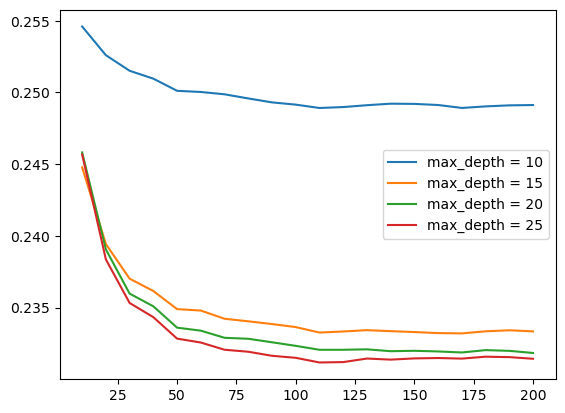

In [24]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'max_depth = {d}')
    
plt.legend()
plt.show()

**Answer Question 4:** 25

## Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- n_estimators=10,
- max_depth=20,
- random_state=1,
- n_jobs=-1 (optional)

Get the feature importance information from this model

What's the most important feature?

- total_rooms
- **median_income <-**
- total_bedrooms
- longitude


In [30]:
scores= []

rf = RandomForestRegressor(n_estimators=10,
                            random_state=1,
                            max_depth=20,
                            n_jobs=-1)
rf.fit(X_train, y_train)

rf.feature_importances_


array([1.61407558e-02, 3.31967386e-02, 1.01333351e-01, 9.63405488e-02,
       3.63224176e-01, 2.76524800e-03, 3.10900842e-01, 3.56806263e-04,
       4.52770519e-04, 4.45219202e-03, 3.09988869e-02, 1.93726028e-02,
       2.04650818e-02])

In [35]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names_out()
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head(3)

,feature,importance
4,median_income,0.363224
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101333


**Answer Question 5:** median_income

In [29]:
y_pred = rf.predict(X_val)
score = np.sqrt(mean_squared_error(y_val, y_pred))
scores.append((score))

[0.24582005817841776]